<p align="center"><img src="imgs/7-23.png" width=600></p>

위의 계층들을 순서대로 코드로 구현해보면 된다.

In [23]:
from common.util import im2col, col2im
import numpy as np

class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad

    def forward(self, x):
        self.x = x
        FN, C, FH, FW = self.W.shape # 필터개수, 채널, 필터높이, 필터너비
        N, C, H, W = self.x.shape
        out_h = int(1 + (H + 2*self.pad - FH)/self.stride)
        out_w = int(1 + (W + 2*self.pad - FW)/self.stride)
        print('out_h:', out_h)
        print('out_w:', out_w)

        self.col = im2col(self.x, FH, FW, self.stride, self.pad)
        print('col shape:', self.col.shape)
        self.col_W = self.W.reshape(FN, -1).T # 필터전개
        print('self.col_W shape:', self.col_W.shape)
        out = np.dot(self.col, self.col_W) + self.b

        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        return out
    
    def backward(self, dout): # 책에서는 설명하지 않음
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

convoluiton을 하나씩 뜯어보기 위해, 이미지를 아무거나 하나 넣어보자.

(300, 300, 3)


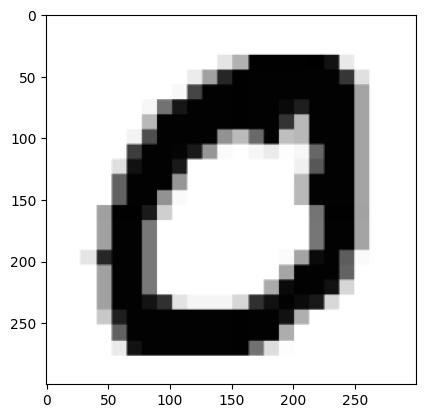

(1, 3, 300, 300)


In [12]:
import cv2
import matplotlib.pyplot as plt
x = cv2.imread('imgs/zero.png')
x = cv2.resize(x, (300, 300))

print(x.shape)
plt.imshow(x)
plt.show()

x = x.transpose(2, 0, 1)
x = np.expand_dims(x, axis=0) # 차원 수를 늘려줌 (convolution에 넣기 위해)
print(x.shape)

* opencv에서 이미지를 읽어오면 (H, W, C) 순으로 들어가는데, 책에서는 (C, H, W) 순으로 설명한다.
* 배치 처리를 하므로, 항상 shape의 맨 앞은 N (이미지 개수)
* 왜 W + b 모양이 다른데 연산이 가능할까? -> 실제로는 bias가 broadcast 되기 때문

In [13]:
W = np.array([2]*300).reshape(1, 3, 10, 10) # N, C, FH, FW
b = np.array([1]*3).reshape(3, 1, 1)

conv = Convolution(W, b)
out = conv.forward(x)
print(1 * 291 * 291) # out_h x out_w
print('out shape:', out.shape) # 곱셈이 왜 동작하는지 shape를 중점적으로 살펴볼 것

out_h: 291
out_w: 291
col shape: (84681, 300)
col_W shape: (300, 1)
84681
out shape: (1, 3, 291, 291)


im2col이 정확히 어떤 원리로 작동하는지는 모르지만.. 몇 가지 알게된 사실이 있다.

* im2col의 목적은 행렬의 곱셈을 위한 것이다. (곱셈을 편하게 하려고 펼쳐주는 역할)
* 각각의 원소들은 모두 input으로부터 오는 것이다. (별도의 곱셈, 다른 행렬 개입 안 함)
* output shape를 살펴보면, 첫 번째 차원은 output_shape와 관련이 있고, <br> 두번째 차원은 weight의 차원과 관련이 있다. (여기서 weight는 kernel/filter와 동일 의미로 쓰임)

정리: convolution의 forward를 거치게 되면, 이미지와 필터의 연산 결과가 나온다. (패딩까지 거친 것)

In [25]:
from collections import OrderedDict
from common.layers import Relu, Pooling, Affine, SoftmaxWithLoss

class SimpleConvNet:
    def __init__(self, input_dim = (1, 28, 28),
                 conv_param={'filter_num': 30, 'filter_size': 5,
                             'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1] # 28
        
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # initialize weight and bias -----------------------------------------------
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(
                                                filter_num, input_dim[0],
                                                filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * np.random.randn(
                                                pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # define layers-------------------------------------------------------------
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])

        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for k, layer in self.layers.items():
            
            x = layer.forward(x)
            print(k, x.shape)
        return x
    
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y ,t)
    

    def gradient(self, x, t):
    
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Conv1'].dW
        grads['b1'] = self.layers['Conv1'].db
        grads['W2'] = self.layers['Affine1'].dW
        grads['b2'] = self.layers['Affine1'].db
        grads['W3'] = self.layers['Affine2'].dW
        grads['b3'] = self.layers['Affine2'].db

        return grads


In [15]:
x = cv2.imread('imgs/zero.png', 0)
x = cv2.resize(x, (28, 28))

x = np.expand_dims(x, axis=0)
x = np.expand_dims(x, axis=0)
print(x.shape)

conv = SimpleConvNet()
conv.predict(x)

(1, 1, 28, 28)
out_h: 24
out_w: 24
col shape: (576, 25)
col_W shape: (25, 30)
Conv1 (1, 30, 24, 24)
Relu1 (1, 30, 24, 24)
Pool1 (1, 30, 12, 12)
Affine1 (1, 100)
Relu2 (1, 100)
Affine2 (1, 10)


array([[-0.09180698,  0.09401261, -0.02633058,  0.01313055, -0.01488398,
         0.3512742 ,  0.74371533, -0.26237844, -0.14738869, -0.30274706]])

<p align="center"><img src="imgs/7-23-2.png" width=800></p>

* 여기 그림에서는 행렬곱이 아니라, 컨볼루션 연산이라는 점 상기
* 렐루 함수를 거치면? -> element-wise 연산이다.
* pooling을 거치면 크기가 반으로 줄어드는 이유? -> pooling_stride = 2 라서



In [16]:
conv = SimpleConvNet()
conv.predict(x) # 스크롤 올리기 귀찮아서 한번 더

out_h: 24
out_w: 24
col shape: (576, 25)
col_W shape: (25, 30)
Conv1 (1, 30, 24, 24)
Relu1 (1, 30, 24, 24)
Pool1 (1, 30, 12, 12)
Affine1 (1, 100)
Relu2 (1, 100)
Affine2 (1, 10)


array([[ 0.26488818,  0.01174983, -0.47830995,  0.04593951, -0.72914841,
        -0.37771665,  0.36843294, -0.06644674,  0.21642373, -0.35672596]])

### Affine1 계층 설명

<p align="center"><img src="imgs/7-23-3.png" width=800></p>

In [17]:
# Pool1 (1, 30, 12, 12) <- 위에 보면 된다
print(12 * 12 * 30)
print('W2 shape:', conv.params['W2'].shape)
print('b2 shape:', conv.params['b2'].shape)

4320
W2 shape: (4320, 100)
b2 shape: (100,)


### Affine2 계층 설명

<p align="center"><img src="imgs/7-23-4.png" width=600></p>

In [18]:
print('W3 shape:', conv.params['W3'].shape)
print('b3 shape:', conv.params['b3'].shape)

W3 shape: (100, 10)
b3 shape: (10,)


### 학습

In [19]:
from common.optimizer import *
from dataset.mnist import load_mnist

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))

In [27]:
from common.simple_convnet import SimpleConvNet

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

train loss:2.300177861899461
=== epoch:1, train acc:0.229, test acc:0.223 ===
train loss:2.2980584458726114
train loss:2.293705286261003
train loss:2.2876166868191103
train loss:2.284209240423866
train loss:2.2715181203737935
train loss:2.262268965544775
train loss:2.246694304104042
train loss:2.2395524836144727
train loss:2.16842030127059
train loss:2.181955900235561
train loss:2.15036487053864
train loss:2.121709996542082
train loss:2.068778124544357
train loss:2.02429084000044
train loss:1.9853480420786083
train loss:1.9145568912345694
train loss:1.8592888567144912
train loss:1.788436466990922
train loss:1.7344000075947954
train loss:1.6955771384291543
train loss:1.513899438447208
train loss:1.3972535799101429
train loss:1.367995221219077
train loss:1.3279235355277204
train loss:1.1682030662890002
train loss:1.167122824612464
train loss:1.182796805661198
train loss:0.9172824328484671
train loss:0.9725829480862646
train loss:1.0172312757666986
train loss:0.9567129805388145
train loss

KeyboardInterrupt: 

* 책코드와 깃허브 코드가 다름 (self.conv) + backward 없음